<a href="https://colab.research.google.com/github/camdenmcgath/Artificial-Judge/blob/master/supreme_court_judge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install evaluate transformers seaborn tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import re
import random
from tabulate import tabulate
import evaluate
import numpy as np
import transformers as trans
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.optim import AdamW, lr_scheduler
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
import nltk
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import trange
import os
import gc
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2048"


In [3]:
cases = pd.read_csv("justice.csv")
cases.drop(columns=['Unnamed: 0', 'ID', 'name', 'href', 'docket', 'term',  
                    'majority_vote', 'minority_vote', 'decision_type', 'disposition', 'issue_area'], inplace=True)
cases.dropna(inplace=True)


In [4]:
cases = cases.rename(columns={'first_party_winner': 'winning_party_idx'})
for i, row in cases.iterrows():
    if row['winning_party_idx'] == True:
        cases.loc[i, 'winning_party_idx'] = 0
    else:
        cases.loc[i, 'winning_party_idx'] = 1

In [5]:

# Create a mirrored case for each case, where the parties are swapped to prevent favoring first_party
mirrored_cases = cases.copy()
mirrored_cases['first_party'], mirrored_cases['second_party'] = mirrored_cases['second_party'], mirrored_cases['first_party']
mirrored_cases['winning_party_idx'] = (mirrored_cases['winning_party_idx'] == 0).astype(int)
mirrored_cases.reset_index(drop=True, inplace=True)

cases = pd.concat([cases, mirrored_cases])
cases.reset_index(drop=True, inplace=True)
print(f'There are {len(cases)} cases.')
print(f'There are {len(cases[cases["winning_party_idx"]==0])} rows for class 0.')
print(f'There are {len(cases[cases["winning_party_idx"]==1])} rows for class 1.')

There are 6572 cases.
There are 3286 rows for class 0.
There are 3286 rows for class 1.


In [6]:
cases['facts'] = cases['facts'].str.replace(r'<[^<]+?>', '', regex=True)
cases['facts'] = cases['facts'].str.replace(r'[^a-zA-Z0-9\']', ' ', regex=True)
cases['first_party'] = cases['first_party'].str.replace(r'[^a-zA-Z0-9\']', ' ', regex=True)
cases['second_party'] = cases['second_party'].str.replace(r'[^a-zA-Z0-9\']', ' ', regex=True)
#cases['facts'] = cases['facts'].str.lower()
cases['facts'] = cases.apply(lambda x: f"{x['first_party']} [SEP] {x['second_party']} [SEP] {x['facts']}", axis=1)

def word_count(text):
  return len(text.split())

cases['facts_len'] = cases['facts'].apply(word_count)
cases['facts_len'].describe()

count    6572.000000
mean      184.493914
std        85.980464
min         7.000000
25%       127.000000
50%       173.000000
75%       229.000000
max       993.000000
Name: facts_len, dtype: float64

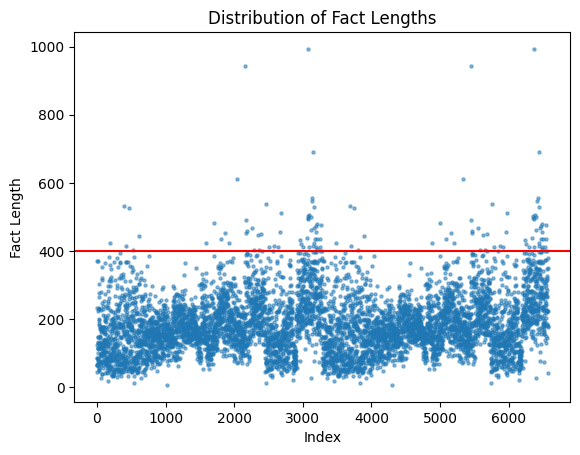


Percentage of cases with fact word no greater than 400: 98.30%


In [7]:
# Create a scatterplot of the fact lengths
plt.scatter(range(len(cases['facts_len'])), cases['facts_len'], s=5, alpha=0.5)

plt.axhline(y=400, color='red')

plt.xlabel('Index')
plt.ylabel('Fact Length')
plt.title('Distribution of Fact Lengths')

plt.show()

# Count the number of facts below 400 length
num_short_facts = len(cases[cases['facts_len'] <= 400])

# Calculate the percentage of short facts
percentage_short_facts = num_short_facts / len(cases) * 100
print(f"\nPercentage of cases with fact word no greater than 400: {percentage_short_facts:.2f}%")

In [8]:
cases = cases[cases['facts_len'] <= 400]
print(cases['facts_len'].describe())

cases = cases.drop(columns=['first_party', 'second_party', 'facts_len'])

#leave truncate flag off to ensure that no data is truncated
#if data is too large this code will not run
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)



count    6460.000000
mean      179.350464
std        75.917270
min         7.000000
25%       126.000000
50%       172.000000
75%       226.000000
max       400.000000
Name: facts_len, dtype: float64


In [9]:
text = cases.facts.values
labels = cases.winning_party_idx.values
print(type(labels))
def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(text)-1)
  table = np.array([tokenizer.tokenize(text[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

#print_rand_sentence()

<class 'numpy.ndarray'>


In [10]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels.astype(np.int64))
#token_id[6]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

#print_rand_sentence_encoding()

In [12]:
train_idx, val_idx = train_test_split(
  np.arange(len(labels)),
  test_size=0.2,
  shuffle=True,
  stratify=labels   
)

In [13]:
# Train and validation sets
train_dataset = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_dataset = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

In [14]:
# Prepare DataLoader
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = 16
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = 16
        )

In [15]:
# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

# Run on GPU
model.cuda()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

In [16]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 5

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


Epoch:  20%|██        | 1/5 [06:26<25:44, 386.01s/it]


	 - Train loss: 0.7089
	 - Validation Accuracy: 0.4997
	 - Validation Precision: NaN
	 - Validation Recall: 0.0000
	 - Validation Specificity: 1.0000



In [ ]:
train_facts, val_facts, train_winners,  val_winners = train_test_split(
    cases['facts'], cases['winning_party_idx'], test_size=0.2, random_state=42)

def describe_facts(txt_df):
  txt_df2 = txt_df.copy()
  txt_df2['word_count'] = txt_df.apply(word_count)
  print(txt_df2['word_count'].describe())

#ensure train/test data has similar text size distribution
describe_facts(train_facts)
describe_facts(val_facts)
print(train_winners.describe())
print(val_winners.describe())

In [ ]:

train_facts, val_facts = train_facts.tolist(), val_facts.tolist()
train_winners, val_winners = [str(i) for i in train_winners], [str(i) for i in val_winners]

train_encodings = tokenizer(train_facts, padding=True)
val_encodings = tokenizer(val_facts, padding=True)

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        type(item)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_winners)
val_dataset = TextDataset(val_encodings, val_winners)


In [ ]:
#Load pretrained model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                      num_labels=2, 
                                                      #hidden_dropout_prob=0.4,
                                                      #attention_probs_dropout_prob=0.4
                                                      )

training_args = TrainingArguments(
    output_dir="test_trainer", 
    logging_dir='logs', 
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    gradient_accumulation_steps=1,
    learning_rate=5e-5,
    logging_steps=50,
)
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()

In [ ]:
# Evaluate on the validation set
result = trainer.predict(val_dataset)

# Extract the predicted and true labels from the evaluation results
y_pred = result.predictions.argmax(axis=1)
y_true = result.label_ids

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()